Udacity - CRISP-DM Project - Stock market prediction (Swiss Market Index)

# 1. BUSINESS UNDERSTANDING

This project is for for identifying features that have predictive value in forecasting price movement of Swiss Market Index, Switzerland’s blue-chip stock market index. We will also train the model using XGBoost, a tree ensemble method and use 20% of the dataset (test data) as validation data.

The following are the questions we will answer:
1. We have 97 fundamental and technical variables. Some variables are redundant and have little values in making trading decisions. Therefore, we would like to identify the 10 variables that stock traders should use in making trading decisions.

2. After identifying the 10 variables, we want to identify which variables serve as buy and sell signals and which variables serve as overbought and oversold signals. For variables generating buy and sell signals, when the values increase/decrease, traders should buy/sell. For variables generating overbought and oversold signals, when the values increase/decrease, traders should sell/buy.

3. When traders buy/sell stock, they must choose when to close the trades. Therefore we would like to identify whether it is more profitable for traders to close their trades after 1, 3 or 5 days.

In [1]:
#installing the necessary modules to extract data from API
!pip install investpy
!pip install yfinance
!pip install pandas_datareader
!pip install pandas_ta

    100% |████████████████████████████████| 4.4MB 5.7MB/s eta 0:00:01  2% |▉                               | 112kB 5.0MB/s eta 0:00:01    11% |███▊                            | 512kB 8.0MB/s eta 0:00:01    22% |███████▍                        | 1.0MB 9.9MB/s eta 0:00:01    37% |████████████                    | 1.6MB 14.2MB/s eta 0:00:01
    100% |████████████████████████████████| 245kB 18.8MB/s ta 0:00:01
    100% |████████████████████████████████| 788kB 14.6MB/s ta 0:00:01
    100% |████████████████████████████████| 13.4MB 2.7MB/s eta 0:00:01   46% |███████████████                 | 6.2MB 21.8MB/s eta 0:00:01    54% |█████████████████▌              | 7.3MB 19.8MB/s eta 0:00:01    61% |███████████████████▉            | 8.3MB 20.2MB/s eta 0:00:01    76% |████████████████████████▋       | 10.3MB 20.3MB/s eta 0:00:01    91% |█████████████████████████████▍  | 12.3MB 20.3MB/s eta 0:00:01
    100% |████████████████████████████████| 9.5MB 4.7MB/s eta 0:00:01   7% |██▎                        

In [2]:
#importing the necessary modules
from pandas_datareader import data as pdr
import numpy as np
import pandas as pd
import investpy
import yfinance as yf
yf.pdr_override() 

# 1. DATA UNDERSTANDING
We will be extracting the following features first from Yahoo Finance API: Stock market index of China, Italy, Netherlands, Austria, Australia, Belgium, India, Hungary, United States, France, United Kingdom, Germany, United States, Canada, Hong Kong, Spain, Ireland, South Korea, Japan, Sweden, Switzerland, Russia, Poland, Denmark and Finland.

We will be extracting daily frequency data and only daily closing price of indices from 01/01/2010 to 31/12/2020

In [4]:
#get indices from Yahoo Finance API. We will be extracting daily frequency data from 01/01/2010 to 31/12/2020
index_data = yf.download("^GSPC ^DJI ^FTSE ^GDAXI FTSEMIB.MI ^FCHI ^IBEX ^AXJO ^HSI ^N225 ^SSMI ^ISEQ ^OMX ^AEX ^ATX \
       ^BFX  ^BUX 000001.SS ^BSESN ^KS11 ^GSPTSE", start="2010-01-01", end="2020-12-31")

#we will only extract the daily closing price of indices
fundamental_indicator = index_data['Close'].fillna(np.nan)
print(fundamental_indicator.head())

#save the extracted data to csv file
fundamental_indicator.to_csv('fundamental_indicator_yahoo.csv')

[*********************100%***********************]  21 of 21 completed
              000001.SS  FTSEMIB.MI        ^AEX         ^ATX        ^AXJO  \
Date                                                                        
2010-01-04  3243.760010     23545.0  343.029999  2537.000000  4876.299805   
2010-01-05  3282.178955     23556.0  342.019989  2593.649902  4924.299805   
2010-01-06  3254.215088     23622.0  341.480011          NaN  4921.399902   
2010-01-07  3192.775879     23709.0  340.549988  2590.620117  4899.399902   
2010-01-08  3195.997070     23811.0  341.940002  2588.489990  4912.100098   

                   ^BFX        ^BSESN          ^BUX          ^DJI  \
Date                                                                
2010-01-04  2563.969971  17558.730469  21561.769531  10583.959961   
2010-01-05  2587.770020  17686.240234  22043.619141  10572.019531   
2010-01-06  2596.429932  17701.130859  22164.720703  10573.679688   
2010-01-07  2590.679932  17615.720703  21961

In [5]:
#we need to rename the columns in fundamental_indicators to, for example China index, will be ShanghaiSE-china
index_list = ['ShanghaiSE', 'ftse mib', 'aex', 'atx', 'asx200', 'bfx', 'bsesn', 'bux', 'djia','cac40', 'ftse100', 'dax30', 's&p500', 'S&P/TSX', 'hang seng', 'ibex 35', 'iseq', 'kospi', 'nikkei225', \
              'omx', '^SSMI']
country_list = ['china', 'italy', 'netherlands', 'austria', 'australia', 'belgium', 'india', 'hungary', 'united states', 'france', 'united kingdom', 'germany', 'united states', 'canada', 'hong kong', \
                'spain', 'ireland', 'south korea', 'japan', 'sweden', 'switzerland' ]

column_names = fundamental_indicator.columns
#this renames the column names
for h,i,j in zip(column_names, index_list, country_list):
    fundamental_indicator = fundamental_indicator.rename(columns= { h : i + '_' + j })

Since I am unable to obtain Russia, Poland, Denmark and Finland indices from Yahoo Finance API, I will
obtain them from Investing.com API(investpy)

In [6]:
#Since I am unable to obtain Russia, Poland, Denmark and Finland indices from Yahoo Finance API, I will
#obtain them from Investing.com API(investpy)
idx = pd.date_range('2010-01-01', '2020-12-31')
index_list_3 = ['moex', 'wig20', 'omxc20', 'omx helsinki 25' ]
country_list_3 = ['russia', 'poland', 'denmark', 'finland']
for i,j in zip(index_list_3, country_list_3):
    df = investpy.get_index_historical_data(index= i,
                                        country= j,
                                        from_date='01/01/2010',
                                        to_date='31/12/2020')
    df_retained = df['Close']

    #due to indices in Investing.com API not having NaN values for certain days due to public holiday, we need to insert rows with
    #with NaN values in those days
    df_retained.index = pd.DatetimeIndex(df_retained.index)
    df_retained_1 = df_retained.reindex(idx, fill_value=np.nan)

    #this adds the new column to the fundamental_indicator dataframe
    fundamental_indicator[j + '-' + i] = df_retained_1

# Exchange Rate Data
We extract exchange rate data from Yahoo Finance API. Since we are predicting closing price of Switzerland stock index, we will pair CHF against another currency
We will be extracting exchange rates of CHF/USD, CHF/GBP, CHF/EUR, CHF/AUD, CHF/HK, CHF/JPY, CHF/DKK, CHF/SEK, CHF/RUB, CHF/NOK, CHF/PLN, CHF/CZK, CHF/HUF, CHF/CN, CHF/INR, CHF/KRW, CHF/CAD. (Note: CHF stands for Swiss franc)

In [7]:
#Now we extract exchange rate data from Yahoo Finance API
#Since we are predicting closing price of Switzerland stock index, we will pair CHF against another currency

currency_data = yf.download("NOKCHF=X CHFUSD=X CHFEUR=X CHFAUD=X CHFHKD=X JPYCHF=X CHFDKK=X CHFSEK=X CHFNOK=X CHFPLN=X CHFCZK=X CHFHUF=X, \
                   CHFCNY=X CHFINR=X CHFKRW=X CHFCAD=X", start="2010-01-01", end="2020-12-31")

exchange_rate = currency_data['Close'].fillna(np.nan)

[*********************100%***********************]  16 of 16 completed


In [8]:
#due to different public holidays in different countries, we need to reindex the indices, bond yield and
#exchange rate data before concatenating them into a single dataframe

idx = pd.date_range('2010-01-01', '2020-12-31')
indicator_list = [fundamental_indicator, exchange_rate]
for i in indicator_list:
    i.index = pd.DatetimeIndex(i.index)
    i = i.reindex(idx, fill_value=np.nan)

#reindex and fill rows with no data with NaN
fundamental_indicator_2 = fundamental_indicator.reindex(idx, fill_value=np.nan)
exchange_rate_2 = exchange_rate.reindex(idx, fill_value=np.nan)
print(fundamental_indicator_2)
print(exchange_rate_2)

#all the 3 dataset have 4018 rows after reindexing
#concatenate the indices, bond yield and exchange rate data into a single dataframe
all_indicators = pd.concat([fundamental_indicator_2, exchange_rate_2], axis = 1)
print(all_indicators)

#after concatenating, dataframe has 4018 rows and 62 columns.(25 for indices, 21 for exchange rate and
#16 for exchange rate)

            ShanghaiSE_china  ftse mib_italy  aex_netherlands  atx_austria  \
2010-01-01               NaN             NaN              NaN          NaN   
2010-01-02               NaN             NaN              NaN          NaN   
2010-01-03               NaN             NaN              NaN          NaN   
2010-01-04       3243.760010         23545.0       343.029999  2537.000000   
2010-01-05       3282.178955         23556.0       342.019989  2593.649902   
...                      ...             ...              ...          ...   
2020-12-27               NaN             NaN              NaN          NaN   
2020-12-28       3397.284912         22289.0       627.590027  2761.709961   
2020-12-29       3379.035889         22259.0       629.140015  2778.229980   
2020-12-30       3414.452881         22233.0       628.059998  2780.439941   
2020-12-31               NaN             NaN              NaN          NaN   

            asx200_australia  bfx_belgium   bsesn_india   bux_h

# Technical variables
Now we will be using pandas_ta module to extract technical indicator variables. We will be using 3, 5, 7, 10, 15, 20, 25 and 30 days in the past to calculate our technical indicators.

Since we will be forecasting Switzerland stock index, we need to extract Open, Close, High and Low daily price
which are used to calculate the technical indicators.

We will be extracting these technical variables: simple moving average, exponential moving average, average true range, relative strength index, average directional index and stochastic oscillators.

In [9]:
!pip install dataclasses

In [11]:
#Now we will be using pandas_ta module to extract technical indicator variables.
#We will be using 3, 5, 7, 10, 15, 20, 25 and 30 days in the past for our technical indicators.

import pandas_ta as ta
length = [3, 5, 7, 10, 15, 20, 25, 30]
#Since we will be forecasting Switzerland stock index, we need to extract Open,Close,High and Low daily price
#which are used to calculate the technical indicators
df_smi = investpy.get_index_historical_data(index= 'smi', country= 'switzerland', from_date='01/01/2010',
                                            to_date='31/12/2020')
df_smi_close = df_smi['Close']
df_smi_high = df_smi['High']
df_smi_low = df_smi['Low']
df_smi_open = df_smi['Open']

#extracting simple moving average
sma_ta = pd.DataFrame()
for i in length:
    sma_ta_1 = ta.sma(df_smi_close, length = i)
    sma_ta['sma_' + str(i) ] = sma_ta_1

#extracting exponential moving average
ema_ta = pd.DataFrame()
for i in length:
    ema_ta_1 = ta.ema(df_smi_close, length = i)
    ema_ta['ema_' + str(i)] = ema_ta_1

#extracting average true range
atr_ta = pd.DataFrame()
for i in length:
    atr_ta_1 = ta.atr(df_smi_high, df_smi_low, df_smi_close, length = i)
    ema_ta['atr_' + str(i)] = atr_ta_1

#extracting relative strength index
rsi_ta = pd.DataFrame()
for i in length:
    rsi_ta_1 = ta.rsi(df_smi_close, length = i)
    rsi_ta['rsi_' + str(i)] = rsi_ta_1

#extracting average directional index
adx_ta = pd.DataFrame()
for i in length:
    adx_ta_1 = ta.adx(df_smi_high, df_smi_low, df_smi_close, length = i)
    #print(adx_ta_1)
    adx_ta['adx_' + str(i)] = adx_ta_1.iloc[:,0]

#extracting stochastic oscillators
stoch_k_ta = pd.DataFrame()
stoch_d_ta = pd.DataFrame()
for i in length:
    stoch_ta_1 = ta.stoch(df_smi_high, df_smi_low, df_smi_close, k = i, d = 3, smooth_k = i)
    stoch_k_ta['stoch_k_' + str(i)] = stoch_ta_1.iloc[:,0]
    stoch_d_ta['stoch_d_' + str(i)] = stoch_ta_1.iloc[:,1]

# 3. Data Preparation
We will concatenate all the fundamental and technical variables extracted into a single dataframe.
We will convert convert all variables data type to float. 
To fill missing values, we use linear interpolation since this is sequential data. We will forward fill first then backward fill.
To remove seasonality and trend from the data, we will apply logarithm difference on the data.

In [12]:
#concatenate all technical indicator variables into a single dataframe
technical_indicators = pd.concat([sma_ta, ema_ta, atr_ta, rsi_ta, adx_ta, stoch_k_ta, stoch_d_ta], axis = 1)

#reindexing the concatenated dataframe
technical_indicators_2 = technical_indicators.reindex(idx, fill_value=np.nan)
#concatenate the previous fundamental indicators with technical indicators
all_indicators_funda_tech = pd.concat([all_indicators, technical_indicators_2], axis = 1)

#convert all variables data type to float
all_indicators_funda_tech_2 = all_indicators_funda_tech.astype(float)
#since first 3 rows of dataframe are all missing values, we exclude them
all_indicators_funda_tech_2 = all_indicators_funda_tech_2.iloc[3:,:]
#to fill missing values, we use linear interpolation since this is sequential data
all_indicators_funda_tech_2 = all_indicators_funda_tech_2.interpolate().ffill().bfill()
#since up to 84 rows for stochastic %D have missing values, causing linear interpolation to fill them with same values,
#I have to remove the first 84 rows
all_indicators_funda_tech_2 = all_indicators_funda_tech_2.iloc[84:-1,:]

#to remove seasonality and trend from the data, i have to apply logarithm difference
log_return_all_indicators = pd.DataFrame()
column_names_1 = all_indicators_funda_tech_2.columns

log_return_all_indicators = np.log(all_indicators_funda_tech_2).diff()

Since our target variables are 1, 3 and 5-day returns, we have to apply 1,3 and 5 days period differencing on the closing price
data of Swiss Market Index.
We will drop missing value after that

In [13]:
# We now extract Switzerland stock index closing price data since this is our target variable
switzerland_index_data = yf.download("^SSMI", start="2010-01-01", end="2020-12-31")
switzerland_index_data_close = switzerland_index_data['Close']

#We would include 1, 3 and 5 days for our forecast horizon
switzerland_forecast_horizon_return = pd.DataFrame()
#convert all values to natural log
switzerland_index_data_close = np.log(switzerland_index_data_close)
forecast_horizon = [1, 3, 5]

#we need to do 1,3 and 5 days period differencing to get the returns
for i in forecast_horizon:
    switzerland_forecast_horizon_return['forecast horizon_' + str(i) + '_day'] = switzerland_index_data_close.diff(periods = i)

k = 0
for i in forecast_horizon:
    switzerland_forecast_horizon_return.iloc[:,k] = switzerland_forecast_horizon_return.shift(-i)
    k += 1

#drop missing values
switzerland_forecast_horizon_return = switzerland_forecast_horizon_return.dropna()

[*********************100%***********************]  1 of 1 completed


In [14]:
#we need to merge the Switzerland stock index return with the independent features.
all_indicators_with_forecast_return =pd.merge(log_return_all_indicators, switzerland_forecast_horizon_return, how="right",
    on=None, left_on=None, right_on=None, left_index=True, right_index=True, sort=True, suffixes=("_x", "_y"), copy=True,
    indicator=False, validate=None)
all_indicators_with_forecast_return = all_indicators_with_forecast_return.dropna()
forecast_return_classification = all_indicators_with_forecast_return.iloc[:,-3:]

We would need to split the dataset into 75% training data and 25% test data
We need to convert the returns for our target variables into binary values: 1 for upward movement and 0 for downward movement

In [15]:
from sklearn.ensemble import RandomForestClassifier

#we would need to split the dataset into 75% training data and 25% test data
total_rows = all_indicators_with_forecast_return.shape[0]
training_size = int(0.75 * total_rows)
X_train = all_indicators_with_forecast_return.iloc[:training_size,:-3]
X_test = all_indicators_with_forecast_return.iloc[training_size:,:-3]

#we need to convert the returns for our target variables into binary values: 1 for upward movement
#and 0 for downward movement
forecast_return_classification_binary = ((forecast_return_classification.values) > 0).astype(int)

#we then split the target variable into y_train and y_test
y_train = forecast_return_classification_binary[:training_size,:]
y_test = forecast_return_classification_binary[training_size:,:]

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


We will be answering our questions now.
# Question 1
We have 97 fundamental and technical variables. Some variables are redundant and have little values in making trading decisions. Therefore, we would like to identify the 10 variables that stock traders should use in making trading decisions.

A: To find the 10 most important features, we will use mutual info classification. We then sort the features from highest weight to lowest weight and display the 10 most important features and the corresponding weights in horizontal bar chart. 

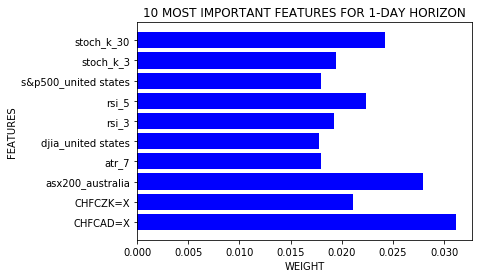

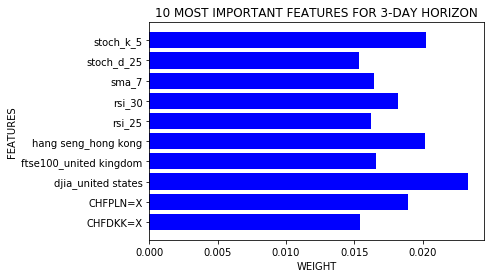

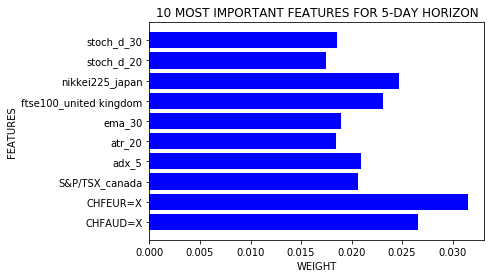

In [17]:
#To find the 10 most important features, we will use chi squared test and mutual info classification
from sklearn.feature_selection import chi2, mutual_info_regression, mutual_info_classif
from sklearn.feature_selection import SelectKBest
Days = [1, 3, 5]
for i in range(3):
    selected_features = SelectKBest(mutual_info_classif, k=10).fit(X_train, y_train[:,i])
    column_names = X_train.columns
    interesting_features_df = pd.DataFrame(selected_features.scores_, index=column_names).rename(columns={0:'feature weight'})

    #this sorts the features from highest weight to lowest weight
    interesting_features_df = interesting_features_df.sort_values('feature weight', ascending=False)

    #this displays the 10 most important features in horizontal bar chart and the corresponding weights
    import matplotlib.pyplot as plt
    Features = interesting_features_df.index[0:10].to_list()[::-1]
    Weight = interesting_features_df['feature weight'][0:10].to_list()[::-1]
    
    plt.barh(Features, Weight, color='blue')
    plt.title('10 MOST IMPORTANT FEATURES ' + 'FOR ' + str(Days[i]) + '-DAY HORIZON')
    plt.ylabel('FEATURES')
    plt.xlabel('WEIGHT')
    plt.show()

## Findings
1. For 1-day forecast horizon, traders should use the following variables: stochastic %K (30-days), stochastic %K (3-days), S&P500, Relative Strength Index (5-days), Relative Strength Index (3-days), Dow Jones Industrial Index (DJIA), Average True Range (7-days), ASX200, CHF/CZK and CHF/CAD.

2. For 3-day forecast horizon, traders should use the following variables: stochastic %K (5-days), stochastic %D (25-days), Simple Moving Average (7-days), S&P500, Relative Strength Index (30-days), Relative Strength Index (25-days), Hang Seng Index, FTSE100, Dow Jones Industrial Index (DJIA) , CHF/PLN and CHF/DKK

3. For 5-day forecast horizon, traders should use the following variables: stochastic %D (30-days), stochastic %D (20-days), Nikkei225 Index, FTSE100, Exponential Moving Average (30-days), Average True Range (20 days), Average Directional Index (5-days), S&P/TSX index, CHF/EUR and CHF/AUD

For completeness of analysis, we will also use chi squared test to find the 10 most important features. Since chi-squared test only accept positive values, we will use min-max scaler to convert values to [0,1] range

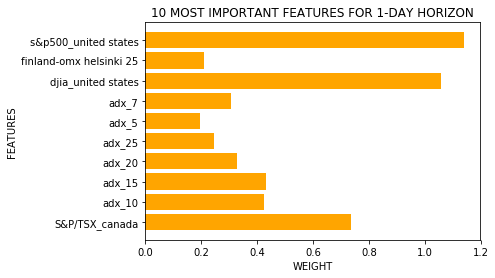

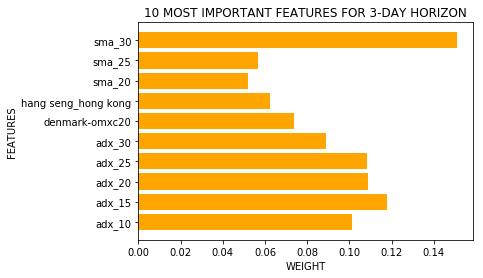

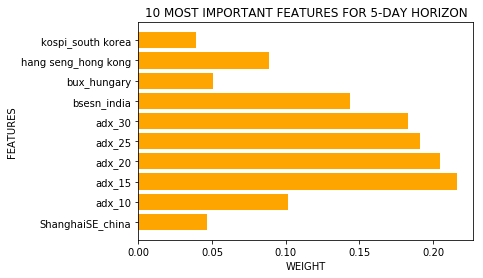

In [18]:
#this is the chi squared test to find the 10 most important features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
Days = [1, 3, 5]
for i in range(3):
    selected_features = SelectKBest(chi2, k=10).fit(X_train_scaled, y_train[:,i])
    interesting_features_df = pd.DataFrame(selected_features.scores_, index=column_names).rename(columns={0:'feature weight'})

    #this sorts the features from highest weight to lowest weight
    interesting_features_df = interesting_features_df.sort_values('feature weight', ascending=False)

    #this displays the 10 most important features in horizontal bar chart and the corresponding weights
    import matplotlib.pyplot as plt
    Features = interesting_features_df.index[0:10].to_list()[::-1]
    Weight = interesting_features_df['feature weight'][0:10].to_list()[::-1]

    plt.barh(Features, Weight, color='orange')
    plt.title('10 MOST IMPORTANT FEATURES ' + 'FOR ' + str(Days[i]) + '-DAY HORIZON')
    plt.ylabel('FEATURES')
    plt.xlabel('WEIGHT')
    plt.show()

## Findings
1. For 1-day forecast horizon, traders should use the following variables: S&P500, OMX Helsinki 25, Average Directional Index (7-days), Average Directional Index (5-days), Average Directional Index (25-days), Average Directional Index (20-days), Average Directional Index (15-days), Average Directional Index (10-days) and S&P/TSX index

2. For 3-day forecast horizon, traders should use the following variables: Simple Moving Average (30-days), Simple Moving Average (25-days), Simple Moving Average (20-days), Hang Seng index, OMX Copenhagen 20 index, Average Directional Index (30-days), Average Directional Index (25-days), Average Directional Index (20-days), Average Directional Index (15-days), Average Directional Index (10-days)

3. For 5-day forecast horizon, traders should use the following variables: Kospi index, Hang Seng index, Budapest Index (BUX), BSE Sensex Index, Average Directional Index (30-days), Average Directional Index (25-days), Average Directional Index (20-days), Average Directional Index (15-days), Average Directional Index (10-days) and Shanghai Stock Index.

It seems that Average Directional Index has high predictive value given its frequent occurrences in the top 10 most important variables for all 3 forecast horizons.

# Question 2:
To find out which variables serve as buy/sell signals and which variables serve as overbought/oversold signals, we will be using Pearson correlation coefficient. They will be presented in bar graph. Therefore variables with positive values (green bars) serve as buy/sell signals and variables with negative values (red bars) serve as overbought/oversold signals.

We will only be using the 10 most important features as identified by mutual information classification.

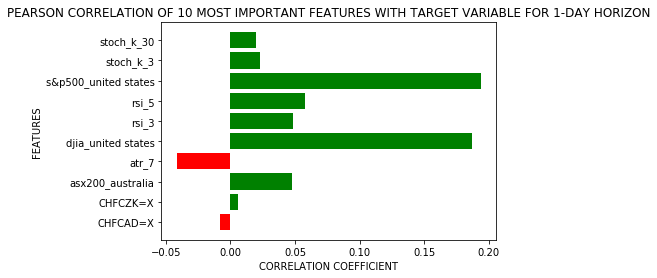

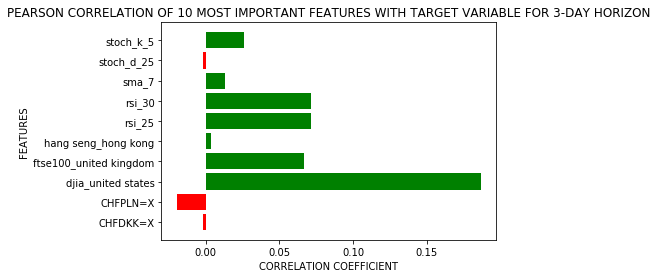

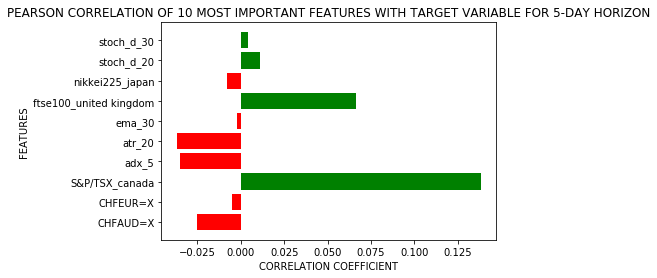

In [19]:
#for the ten most important features for forecast horizon of 1, 3 and 5 days, we find the correlation coefficient
#between the features and target variable
import scipy
for k in range(3):
    selected_features = SelectKBest(mutual_info_classif, k=10).fit(X_train, y_train[:,k])
    interesting_features_df = pd.DataFrame(selected_features.scores_, index=column_names).rename(columns={0:'feature weight'})
    interesting_features_df = interesting_features_df.sort_values('feature weight', ascending=False)
    features = interesting_features_df.index[0:10].to_list()[::-1]

    #appends the correlation coefficient results to pearson_corr list
    pearson_corr = []
    for i in features:
        corr = scipy.stats.pearsonr(y_train[:,0],X_train[i])[0]
        pearson_corr.append(corr)

    features_neg = []
    pearson_corr_neg = []
    for i,j in zip(features,pearson_corr):
        if j < 0:
            pearson_corr_neg.append(j)
            features_neg.append(i)

    #plot the 10 features and the corresponding correlation coefficient
    #fig = plt.figure(figsize=(4, 3))
    plt.barh(features, pearson_corr, color='green')
    plt.barh(features_neg, pearson_corr_neg, color='red')
    plt.title('PEARSON CORRELATION OF 10 MOST IMPORTANT FEATURES WITH TARGET VARIABLE ' + 'FOR ' + str(Days[k]) + '-DAY HORIZON')
    plt.ylabel('FEATURES')
    plt.xlabel('CORRELATION COEFFICIENT')
    plt.show()

Findings
1. For 1-day forecast horizon, stochastic %K (30-days), stochastic %K (3-days), S&P500, Relative Strength Index (5-days), Relative Strength Index (3-days), Dow Jones Industrial Index (DJIA), ASX200 and CHF/CZK serve as buy/sell signals while Average True Range (7-days) and CHF/CAD serve as overbought/oversold signals.

2. For 3-day forecast horizon, stochastic %K (5-days), Simple Moving Average (7-days), S&P500, Relative Strength Index (30-days), Relative Strength Index (25-days), Hang Seng Index, FTSE100, Dow Jones Industrial Index (DJIA) serve as buy/sell signals while stochastic %D (25-days),CHF/PLN and CHF/DKK serve as overbought/oversold signals.

3. For 5-day forecast horizon, Nikkei225 Index, Exponential Moving Average (30-days), Average True Range (20 days), Average Directional Index (5-days), CHF/EUR and CHF/AUD serve as buy/sell signals while stochastic %D (30-days), stochastic %D (20-days), FTSE100 and S&P/TSX index serve as overbought/oversold signals.

Therefore for buy/sell signals, traders should buy/sell when the variables increase/decrease in values and for overbought/oversold signals, traders should sell/buy when variables increase/decrease in values.

# 4. MODELING
We would now train our model. We will be using XGBoost machine- learning algorithm. We decided to use tree-based ensemble method because it will ignore redundant or correlated features in constructing ensemble of trees. While it is a greedy algorithm in that it chooses the best feature to split at that time but not the best overall, it is robust to overfitting and has proven to acquire the best score in Kaggle competition.
For hyperparameters optimization, we used Bayesian optimisation which is better than random search and grid search.
We will train on training data and use test data as our validation data.

In [33]:
#importing the necessary modules for bayesian optimization
import ast
import csv
import inspect
import sys
import time
from time import gmtime, strftime
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import xgboost as xgb
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, f1_score
import pickle
import tensorflow_addons as tfa

In [ ]:
results_file = "bayes_optimization_summary_{}.csv".format(
    strftime("%y%m%d%H%M", gmtime())
)

#used to name the csv file for recording accuracy and F1 scores and hyperparameters combination
with open(results_file, "w", newline="") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(
        [
            "iteration",
            "loss",
            "accuracy_score",
            "f1_score"
            "train_time",
            "params",
        ]
    )

In [ ]:
def objective(space):
    """
    Bayesian Optimisation function to find optimal hyperparameter combination
    
    Arguments:
        space -> hyperparameter combinations
    Outputs:
        loss -> loss from predictions made on evaluation data
    
    """
    global ITERATION
    ITERATION += 1
    start = timer()
    global predictions_all

    
    #train the XGBClassifier model on training data and test data is used as validation data with early stopping round set at 40
    eval_set = [(X_test, y_test[:,2])]
    xgbcl = xgb.XGBClassifier(colsample_bytree =  space['colsample_bytree'], gamma = space['gamma'], learning_rate = space['learning_rate'], max_depth = space['max_depth'], min_child_weight = space['min_child_weight'], n_estimators = space['n_estimators'], reg_alpha = space['reg_alpha'], scale_pos_weight = space['scale_pos_weight'], subsample = space['subsample'], tree_method = 'gpu_hist', sampling_method = 'gradient_based')
    xgbcl.fit(X_train, y_train[:,2], early_stopping_rounds=40, eval_metric="error@0.55", eval_set=eval_set)
    #the trained model is used to predict on the test data
    prediction = xgbcl.predict(X_test)
    predictions_all = pd.concat([predictions_all, pd.DataFrame(prediction).rename(columns={0:ITERATION})], axis=1)
    #obtain the accuracy and f1 score
    acc = accuracy_score(y_test[:,2], prediction)
    f1 = f1_score(y_test[:,2], prediction) 

    # log runtime
    run_time = timer() - start

    # calculate loss based on scoring method
    loss = 1 - acc
    
    # export results to csv
    out_file = results_file
    with open(out_file, "a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(
            [
                ITERATION,
                loss,
                acc,
                f1,
                run_time,
                space
            ]
        )

    return loss

In [ ]:
#this is the hyperparameter search space for XGBoost Classifier
space = { 'learning_rate': hp.uniform('learning_rate', 0.001, 0.050),
'max_depth': hp.choice('max_depth', np.arange(4, 14, 1, dtype=int)),
'min_child_weight': hp.choice('min_child_weight', np.arange(1, 20, 1, dtype = int)),
'gamma': hp.uniform('gamma', 0.04, 0.4),
'subsample': hp.uniform('subsample', 0.5, 1.0),
'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
'reg_alpha': hp.uniform('reg_alpha', 0.002 , 0.04),
'n_estimators': hp.choice('n_estimators', np.arange(200, 500,1, dtype = int)),
'scale_pos_weight': hp.choice('scale_pos_weight', np.arange(10, 50, 1, dtype=int)),
'tree_method' :'gpu_hist',
'sampling_method' : 'gradient_based'
          }

In [ ]:
#this line of codes initiates the bayesian optimisation procedure and I will set maximum iterations at 400
ITERATION=0
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=400,
    trials=Trials(),
    show_progressbar=True,
)

# 5. EVALUATION
We will be evaluating our model using accuracy and F1 score for predictions made on test data. After performing bayesian optimization, we will select the top 3 models based on accuracy/F1 scores for forecast horizon of 1,3 and 5-days and we will answer the following question:

## Question 3:
To find out which forecast horizon (1 , 3 or 5 days) is more profitable for stock traders, we will be using accuracy and F1 scores. Therefore using accuracy and F1 score as evaluation metric, we would like to find which forecast horizon is more profitable for making trading decisions.

In [34]:
#The accuracy and F1 score for top 3 models for 1-day horizon
Accuracy_1day = [0.572065379, 0.570579495, 0.560178306]
F1_1day = [0.688984881, 0.704800817, 0.704]
#Mean accuracy and F1 score for top 3 models for 1-day horizon
Accuracy_1day_mean = sum(Accuracy_1day)/3
F1_1day_mean = sum(F1_1day)/3

#The accuracy and F1 score for top 3 models for 3-day horizon
Accuracy_3day = [0.543833581, 0.539375929, 0.537890045]
F1_3day = [0.699902248, 0.684317719, 0.696585366]
#Mean accuracy and F1 score for top 3 models for 3-day horizon
Accuracy_3day_mean = sum(Accuracy_3day)/3
F1_3day_mean = sum(F1_3day)/3

#The accuracy and F1 score for top 3 models for 5-day horizon
Accuracy_5day = [0.548291233, 0.548291233, 0.545319465]
F1_5day = [0.693548387, 0.700787402, 0.701171875]
#Mean accuracy and F1 score for top 3 models for 5-day horizon
Accuracy_5day_mean = sum(Accuracy_5day)/3
F1_5day_mean = sum(F1_5day)/3

## Findings
We will tabulate the mean accuracy and F1 score for forecast horizon of 1, 3 and 5-days in table format. As can be seen, 1-day forecast horizon has the highest mean accuracy and also F1 score. Thus when stock traders initiates a trade, they should close their position after 1 day.

In [35]:
mean_accuracy = pd.DataFrame([Accuracy_1day_mean, Accuracy_3day_mean, Accuracy_5day_mean]).rename(columns={0:'mean accuracy'})
mean_F1 = pd.DataFrame([F1_1day_mean, F1_3day_mean, F1_5day_mean]).rename(columns={0:'mean F1'})
horizon = ['1-day horizon', '3-day horizon', '5-day horizon']
table_score = pd.concat([mean_accuracy, mean_F1], axis = 1).set_index(np.array(horizon))

print(table_score)

               mean accuracy   mean F1
1-day horizon       0.567608  0.699262
3-day horizon       0.540367  0.693602
5-day horizon       0.547301  0.698503
